# KGOT algothrim snapshot

## Code improved

### KGOT algorithm

#### Straightening

In [27]:
import json
import numpy as np
import cv2
from pycocotools import mask as mask_utils
from scipy.interpolate import interp1d
import os
from skimage.draw import line
import time


def interpolate_centerline(keypoints, num_points):
    t = np.linspace(0, 1, len(keypoints))
    t_new = np.linspace(0, 1, num_points)
    fx = interp1d(t, keypoints[:, 0], kind='cubic', bounds_error=False, fill_value="extrapolate")
    fy = interp1d(t, keypoints[:, 1], kind='cubic', bounds_error=False, fill_value="extrapolate")
    return np.column_stack((fx(t_new), fy(t_new)))

def calculate_tangents_and_normals(points):
    tangents = np.gradient(points, axis=0)
    tangents = tangents / np.linalg.norm(tangents, axis=1)[:, np.newaxis]
    normals = np.column_stack((-tangents[:, 1], tangents[:, 0]))
    return tangents, normals

def prepare_centerline(centerline, num_segments):
    centerline_interp = interpolate_centerline(centerline, num_segments * 10)
    _, normals = calculate_tangents_and_normals(centerline_interp)
    indices = np.linspace(0, len(centerline_interp) - 1, num_segments + 1, dtype=int)
    selected_points = centerline_interp[indices]
    return centerline_interp, normals, indices, selected_points

def calculate_width_and_fill_mask(mask, point, normal, segment_mask=None):
    width = 0
    for direction in [1, -1]:
        current_point = np.array(point, dtype=float)
        while True:
            x, y = np.round(current_point).astype(int)
            if x < 0 or x >= mask.shape[1] or y < 0 or y >= mask.shape[0] or mask[y, x] == 0:
                break
            if segment_mask is not None:
                segment_mask[y, x] = 255
            current_point += direction * normal
            width += 1
    return width

def process_segment(mask, start_point, end_point, normal, create_mask=False):
    segment_mask = np.zeros_like(mask, dtype=np.uint8) if create_mask else None
    segment_widths = []
    rr, cc = line(int(start_point[1]), int(start_point[0]), int(end_point[1]), int(end_point[0]))
    
    for r, c in zip(rr, cc):
        width = calculate_width_and_fill_mask(mask, (c, r), normal, segment_mask)
        segment_widths.append(width)
    
    return segment_mask, np.mean(segment_widths)

def process_centerline(mask, centerline, num_segments, create_masks=False):
    centerline_interp, normals, indices, selected_points = prepare_centerline(np.array(centerline), num_segments)

    segment_masks = []
    widths = []

    for i in range(len(selected_points) - 1):
        start_point = selected_points[i]
        end_point = selected_points[i + 1]
        normal = normals[indices[i]]
        
        segment_mask, width = process_segment(mask, start_point, end_point, normal, create_masks)
        
        if create_masks:
            segment_masks.append(segment_mask)
        widths.append(width)

    return segment_masks, widths

def divide_mask_by_centerline(mask, centerline, num_segments=10):
    segment_masks, widths = process_centerline(mask, centerline, num_segments, create_masks=True)
    return segment_masks, widths

def calculate_average_width(mask, centerline, num_segments=10):
    _, widths = process_centerline(mask, centerline, num_segments, create_masks=False)
    return np.mean(widths)

def ensure_rgba(image):
    if image.shape[2] == 3:
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    elif image.shape[2] == 4:
        return cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    return image

def straighten_image(image, keypoints, mask, output_length, output_width):
    h, w = image.shape[:2]
    output_height = int(output_width * (h / w))
    straightened = np.zeros((output_height, int(output_length), 4), dtype=np.uint8)

    # Ensure image is in RGBA format
    image = ensure_rgba(image)
    
    centerline = interpolate_centerline(keypoints, int(output_length))
    _, normals = calculate_tangents_and_normals(centerline)

    for i in range(int(output_length)):
        cx, cy = centerline[i]
        nx, ny = normals[i]

        for j in range(output_height):
            offset = (j - output_height / 2)
            sx, sy = int(cx + offset * nx), int(cy + offset * ny)

            if 0 <= sx < w and 0 <= sy < h and mask[sy, sx]:
                straightened[j, i] = image[sy, sx]
            else:
                straightened[j, i] = [0, 0, 0, 0]

    return straightened

def load_and_preprocess_image(image_path):
    # Read image in BGR format
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    # Convert to RGBA
    return ensure_rgba(image)

def save_straightened_image(image, output_path):
    cv2.imwrite(output_path, image, [cv2.IMWRITE_PNG_COMPRESSION, 9])

In [28]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import cv2

def generate_reference_curve(keypoints, num_points=1000, target_length=None):
    distances = np.linalg.norm(np.diff(keypoints, axis=0), axis=1)
    original_total_length = np.sum(distances)
    
    print(f"Original length: {original_total_length:.2f}")
    print(f"Target length: {target_length}")
    
    if target_length is not None:
        scale_factor = target_length / original_total_length
        scaled_distances = distances * scale_factor
        scaled_cumulative_distances = np.insert(np.cumsum(scaled_distances), 0, 0)
        
        scaled_keypoints = np.zeros_like(keypoints)
        scaled_keypoints[0] = keypoints[0]
        scaled_keypoints[1:] = keypoints[0] + np.cumsum(np.diff(keypoints, axis=0) * scale_factor, axis=0)
        
        t = np.linspace(0, 1, num_points)
        f = interp1d(scaled_cumulative_distances / scaled_cumulative_distances[-1], scaled_keypoints, axis=0, kind='linear')
        smooth_curve = f(t)
        
        sigma = 1 * scale_factor
        smooth_curve = gaussian_filter1d(smooth_curve, sigma, axis=0)
    else:
        scale_factor = 1
        smooth_curve = keypoints
    
    new_length = np.sum(np.linalg.norm(np.diff(smooth_curve, axis=0), axis=1))
    print(f"New length: {new_length:.2f}")
    print(f"Scale factor: {scale_factor:.2f}")
    
    return smooth_curve, scale_factor

def warp_straightened_image(straightened, reference_curve, avg_width, scale_factor=None):
    height, width = straightened.shape[:2]
    
    extended_curve = interpolate_centerline(reference_curve, int(len(reference_curve) * 1.2))
    
    min_x, min_y = np.min(extended_curve, axis=0)
    max_x, max_y = np.max(extended_curve, axis=0)
    
    padding = avg_width
    output_width = int(max_x - min_x + 2 * padding)
    output_height = int(max_y - min_y + 2 * padding)
    
    warped = np.zeros((output_height, output_width, 4), dtype=np.uint8)
    weight = np.zeros((output_height, output_width), dtype=np.float32)
    
    _, normals = calculate_tangents_and_normals(extended_curve)
    
    straightened = ensure_rgba(straightened)
    
    y_coords, x_coords = np.mgrid[0:height, 0:width]
    t = x_coords / width
    curve_indices = np.minimum((t * (len(extended_curve) - 1)).astype(int), len(extended_curve) - 1)
    
    curve_points = extended_curve[curve_indices]
    normal_vectors = normals[curve_indices]
    
    offsets = (y_coords / height - 0.5) * avg_width
    
    warped_coords = curve_points - [min_x, min_y] + [padding, padding] + offsets[:, :, np.newaxis] * normal_vectors
    warped_coords = warped_coords.astype(int)
    
    valid_mask = (warped_coords[:, :, 0] >= 0) & (warped_coords[:, :, 0] < output_width) & \
                 (warped_coords[:, :, 1] >= 0) & (warped_coords[:, :, 1] < output_height)
    
    warped[warped_coords[valid_mask, 1], warped_coords[valid_mask, 0]] = straightened[y_coords[valid_mask], x_coords[valid_mask]]
    weight[warped_coords[valid_mask, 1], warped_coords[valid_mask, 0]] += 1

    mask = (warped[:,:,3] > 0).astype(np.uint8) * 255

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

    contours, _ = cv2.findContours(closed_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    fill_mask = np.zeros_like(mask)
    cv2.drawContours(fill_mask, contours, -1, 255, -1)

    kernel_dilate = np.ones((3, 3), np.uint8)
    fill_mask_dilated = cv2.dilate(fill_mask, kernel_dilate, iterations=2)

    transparent_mask = (fill_mask_dilated == 255) & (warped[:,:,3] == 0)
    transparent_mask = (fill_mask == 255) & (warped[:,:,3] == 0)

    warped_filled = warped.copy()
    for i in range(3):
        warped_filled[:,:,i] = cv2.inpaint(warped[:,:,i], transparent_mask.astype(np.uint8), 3, cv2.INPAINT_TELEA)
    
    warped_filled[:,:,3] = np.where(transparent_mask, 255, warped[:,:,3])
    
    # Ensure output is in RGBA format
    warped = cv2.cvtColor(warped, cv2.COLOR_BGRA2RGBA)
    warped_filled = cv2.cvtColor(warped_filled, cv2.COLOR_BGRA2RGBA)

    return warped, warped_filled, warped

## Image processing code 

In [29]:
def circulate_image_from_coco(json_file_path, image_folder, output_folder, output_width=1024, output_height=1024, scale=True):
    with open(json_file_path, 'r') as f:
        coco_data = json.load(f)

    os.makedirs(output_folder, exist_ok=True)

    image_ids = set(ann['image_id'] for ann in coco_data['annotations'])

    frame_images = []

    for ref_image_id in image_ids:
        ref_ann = next((ann for ann in coco_data['annotations'] if ann['image_id'] == ref_image_id), None)
        if ref_ann is None:
            print(f"No annotation found for reference image ID {ref_image_id}")
            continue

        reference_keypoints = np.array(ref_ann['keypoints']).reshape(-1, 3)[:, :2]

        for ann in coco_data['annotations']:
            image_id = ann['image_id']
            image_info = next((img for img in coco_data['images'] if img['id'] == image_id), None)
            if image_info is None:
                print(f"No image info found for image ID {image_id}")
                continue

            image_filename = image_info['file_name']
            image_path = os.path.join(image_folder, image_filename)

            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                continue

            try:
                image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
                if image is None:
                    print(f"Failed to read image: {image_path}")
                    continue
                
                image = ensure_rgba(image)

                keypoints = np.array(ann['keypoints']).reshape(-1, 3)[:, :2]

                rle = ann['segmentation']
                mask = mask_utils.decode(rle)

                _, widths = divide_mask_by_centerline(mask, keypoints)
                avg_width = int(np.mean(widths))

                total_length = np.sum(np.sqrt(np.sum(np.diff(keypoints, axis=0)**2, axis=1)))
                
                straightened = straighten_image(image, keypoints, mask, total_length, avg_width)
                print(f"Straightened image width: {straightened.shape[1]}")

                if scale:
                    reference_curve, scale_factor = generate_reference_curve(reference_keypoints, num_points=10000, target_length=straightened.shape[1])
                else:
                    reference_curve, scale_factor = generate_reference_curve(reference_keypoints, num_points=10000)

                warped, warped_filled, edge = warp_straightened_image(straightened, reference_curve, avg_width, scale_factor)

                if warped_filled.shape[0] > output_height or warped_filled.shape[1] > output_width:
                    scale = min(output_height / warped_filled.shape[0], output_width / warped_filled.shape[1])
                    new_size = (int(warped_filled.shape[1] * scale), int(warped_filled.shape[0] * scale))
                    warped_filled = cv2.resize(warped_filled, new_size, interpolation=cv2.INTER_AREA)
                    edge = cv2.resize(edge, new_size, interpolation=cv2.INTER_NEAREST)

                output = np.zeros((output_height, output_width, 4), dtype=np.uint8)

                y_offset = (output_height - warped_filled.shape[0]) // 2
                x_offset = (output_width - warped_filled.shape[1]) // 2
                output[y_offset:y_offset+warped_filled.shape[0], x_offset:x_offset+warped_filled.shape[1]] = warped_filled

                output_filename = f"{os.path.splitext(image_filename)[0]}_warped_ref_image{ref_image_id}_.png"
                output_path = os.path.join(output_folder, output_filename)
                cv2.imwrite(output_path, output, [cv2.IMWRITE_PNG_COMPRESSION, 9])
                print(f"Processed and saved: {output_filename}")

                frame = np.zeros((output_height, output_width), dtype=np.uint8)
                frame[y_offset:y_offset+warped_filled.shape[0], x_offset:x_offset+warped_filled.shape[1]] = edge
                frame_images.append(frame)

            except Exception as e:
                print(f"Error processing image {image_filename}: {str(e)}")

    return frame_images

In [30]:
# # Usage
# json_file_path = r'D:\Personal_Project\snake_straightening\data\isIDD_v2\label\all_1024\all_annotations_easy_1024.json'
# image_folder = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample'
# output_folder = r'D:\Personal_Project\snake_straightening\graph_generate\trial'

# circulate_image_from_coco(json_file_path, image_folder, output_folder)

Straightening image and output

In [31]:
import json
import os   

def load_and_preprocess_image(image_path):
    if not os.path.exists(image_path):
        print(f"Error: Image file not found: {image_path}")
        return None
    
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        print(f"Error: Unable to load image: {image_path}")
        return None
    
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGBA)
    elif image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
    elif image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    
    return image

def straighten_images_from_coco(json_file_path, image_folder, output_folder):
    with open(json_file_path, 'r') as f:
        coco_data = json.load(f)

    os.makedirs(output_folder, exist_ok=True)

    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        image_info = next((img for img in coco_data['images'] if img['id'] == image_id), None)
        if image_info is None:
            print(f"Error: No image info found for image_id: {image_id}")
            continue
        
        image_filename = image_info['file_name']
        image_path = os.path.join(image_folder, image_filename)
        image = load_and_preprocess_image(image_path)
        
        if image is None:
            continue  # Skip this image and move to the next one
        
        keypoints = np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
        mask = mask_utils.decode(ann['segmentation'])

        _, widths = divide_mask_by_centerline(mask, keypoints)
        avg_width = int(np.mean(widths))
        total_length = np.sum(np.sqrt(np.sum(np.diff(keypoints, axis=0)**2, axis=1)))

        straightened = straighten_image(image, keypoints, mask, total_length, avg_width)

        output_filename = f"{os.path.splitext(image_filename)[0]}_straightened.png"
        output_path = os.path.join(output_folder, output_filename)
        save_straightened_image(straightened, output_path)

        print(f"Processed and saved: {output_filename}")

In [32]:
# # Usage
# json_file_path = r'D:\Personal_Project\snake_straightening\data\isIDD_v2\label\all_1024\all_annotations_easy_1024.json'
# image_folder = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample'
# output_folder = r'D:\Personal_Project\snake_straightening\graph_generate\trial'

# straighten_images_from_coco(json_file_path, image_folder, output_folder)

## Methodology visualize

In [33]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_warped_curve_properties(warped_image, reference_curve, avg_width, scale_factor=None, num_sample_points=15):
    # Create a white background of the same size as the warped image
    h, w = warped_image.shape[:2]
    white_background = np.ones((h, w, 3), dtype=np.uint8) * 255
    
    # Create a mask for non-transparent pixels
    mask = warped_image[:, :, 3] > 0
    
    # Paste the BGR channels of the warped image onto the white background
    white_background[mask] = warped_image[mask, :3]
    
    # Adjust reference curve to match warped image coordinates
    min_x, min_y = np.min(reference_curve, axis=0)
    padding = avg_width
    adjusted_curve = reference_curve - [min_x, min_y] + [padding, padding]

    # Sample points along the curve
    sample_indices = np.linspace(0, len(adjusted_curve) - 1, num_sample_points, dtype=int)
    sampled_points = adjusted_curve[sample_indices]

    # Calculate tangents and normals
    tangents = np.zeros_like(sampled_points)
    normals = np.zeros_like(sampled_points)

    for i in range(len(sampled_points)):
        if i == 0:
            tangent = sampled_points[1] - sampled_points[0]
        elif i == len(sampled_points) - 1:
            tangent = sampled_points[-1] - sampled_points[-2]
        else:
            tangent = sampled_points[i+1] - sampled_points[i-1]
        
        tangent = tangent / np.linalg.norm(tangent)
        normal = np.array([-tangent[1], tangent[0]])
        
        tangents[i] = tangent
        normals[i] = normal

    # Create the plot with white background
    fig, ax = plt.subplots(figsize=(12, 12), facecolor='white')
    
    # Display the image (already in BGR format)
    ax.imshow(white_background)

    # Plot the curve as a blue line
    ax.plot(adjusted_curve[:, 0], adjusted_curve[:, 1], color='blue', linewidth=2, zorder=2, label='Curve')

    # Plot keypoints and add numbers
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], color='lime', s=50, zorder=3, label='Keypoints')
    for i, (x, y) in enumerate(sampled_points, start=1):
        ax.text(x + 5, y + 5, str(i), color='white', fontsize=18, fontweight='bold', 
                ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', pad=0))

    # Plot tangent vectors
    tangent_scale = 30
    ax.quiver(sampled_points[:, 0], sampled_points[:, 1], 
              tangents[:, 0], tangents[:, 1], 
              color='red', scale=1/tangent_scale, scale_units='xy', 
              angles='xy', width=0.004, zorder=4, label='Tangent Vectors')

    # Plot normal vectors in yellow
    normal_scale = 30
    ax.quiver(sampled_points[:, 0], sampled_points[:, 1], 
              normals[:, 0], normals[:, 1], 
              color='yellow', scale=1/normal_scale, scale_units='xy', 
              angles='xy', width=0.004, zorder=4, label='Normal Vectors')

    # Set labels and title with specified font sizes
    ax.set_title('Warped Image with Curve Properties', fontsize=24)

    # Add legend with larger font size
    ax.legend(loc='upper right', fontsize=18)

    # Add grid
    ax.grid(True, linestyle='--', color='gray', alpha=0.5)

    # Set x and y ticks
    x_ticks = np.arange(0, w, 100)
    y_ticks = np.arange(0, h, 100)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(x_ticks, fontsize=12)
    ax.set_yticklabels(y_ticks, fontsize=12)

    # Set the plot limits to match the image size
    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)  # Reverse Y-axis to match image coordinates

    # Adjust layout and display
    plt.tight_layout()
    return fig

In [34]:
def warp_straightened_image(straightened, reference_curve, avg_width, scale_factor=None):
    height, width = straightened.shape[:2]
    
    extended_curve = interpolate_centerline(reference_curve, int(len(reference_curve) * 1.2))
    
    min_x, min_y = np.min(extended_curve, axis=0)
    max_x, max_y = np.max(extended_curve, axis=0)
    
    padding = avg_width
    output_width = int(max_x - min_x + 2 * padding)
    output_height = int(max_y - min_y + 2 * padding)
    
    warped = np.zeros((output_height, output_width, 4), dtype=np.uint8)
    weight = np.zeros((output_height, output_width), dtype=np.float32)
    
    _, normals = calculate_tangents_and_normals(extended_curve)
    
    straightened = ensure_rgba(straightened)
    
    y_coords, x_coords = np.mgrid[0:height, 0:width]
    t = x_coords / width
    curve_indices = np.minimum((t * (len(extended_curve) - 1)).astype(int), len(extended_curve) - 1)
    
    curve_points = extended_curve[curve_indices]
    normal_vectors = normals[curve_indices]
    
    offsets = (y_coords / height - 0.5) * avg_width
    
    warped_coords = curve_points - [min_x, min_y] + [padding, padding] + offsets[:, :, np.newaxis] * normal_vectors
    warped_coords = warped_coords.astype(int)
    
    valid_mask = (warped_coords[:, :, 0] >= 0) & (warped_coords[:, :, 0] < output_width) & \
                 (warped_coords[:, :, 1] >= 0) & (warped_coords[:, :, 1] < output_height)
    
    warped[warped_coords[valid_mask, 1], warped_coords[valid_mask, 0]] = straightened[y_coords[valid_mask], x_coords[valid_mask]]
    weight[warped_coords[valid_mask, 1], warped_coords[valid_mask, 0]] += 1

    mask = (warped[:,:,3] > 0).astype(np.uint8) * 255

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

    contours, _ = cv2.findContours(closed_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    fill_mask = np.zeros_like(mask)
    cv2.drawContours(fill_mask, contours, -1, 255, -1)
    
    transparent_mask = (fill_mask == 255) & (warped[:,:,3] == 0)

    warped_filled = warped.copy()
    for i in range(3):
        warped_filled[:,:,i] = cv2.inpaint(warped[:,:,i], transparent_mask.astype(np.uint8), 3, cv2.INPAINT_TELEA)
    
    warped_filled[:,:,3] = np.where(transparent_mask, 255, warped[:,:,3])

    # After warping is complete, visualize the curve properties
    fig = visualize_warped_curve_properties(warped_filled, extended_curve, avg_width, scale_factor)

    return warped, warped_filled, warped, fig

In [35]:
import numpy as np
import cv2
import json
import os
import pycocotools.mask as mask_utils
import matplotlib.pyplot as plt


def circulate_image_from_coco(json_file_path, image_folder, output_folder, output_width=1024, output_height=1024, scale=True):
    with open(json_file_path, 'r') as f:
        coco_data = json.load(f)

    os.makedirs(output_folder, exist_ok=True)

    image_ids = set(ann['image_id'] for ann in coco_data['annotations'])

    frame_images = []

    for ref_image_id in image_ids:
        ref_ann = next((ann for ann in coco_data['annotations'] if ann['image_id'] == ref_image_id), None)
        if ref_ann is None:
            print(f"No annotation found for reference image ID {ref_image_id}")
            continue

        reference_keypoints = np.array(ref_ann['keypoints']).reshape(-1, 3)[:, :2]

        for ann in coco_data['annotations']:
            image_id = ann['image_id']
            image_info = next((img for img in coco_data['images'] if img['id'] == image_id), None)
            if image_info is None:
                print(f"No image info found for image ID {image_id}")
                continue

            image_filename = image_info['file_name']
            image_path = os.path.join(image_folder, image_filename)

            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                continue

            try:
                image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
                if image is None:
                    print(f"Failed to read image: {image_path}")
                    continue
                
                image = ensure_rgba(image)

                keypoints = np.array(ann['keypoints']).reshape(-1, 3)[:, :2]

                rle = ann['segmentation']
                mask = mask_utils.decode(rle)

                _, widths = divide_mask_by_centerline(mask, keypoints)
                avg_width = int(np.mean(widths))

                total_length = np.sum(np.sqrt(np.sum(np.diff(keypoints, axis=0)**2, axis=1)))
                
                straightened = straighten_image(image, keypoints, mask, total_length, avg_width)
                print(f"Straightened image width: {straightened.shape[1]}")

                if scale:
                    reference_curve, scale_factor = generate_reference_curve(reference_keypoints, num_points=10000, target_length=straightened.shape[1])
                else:
                    reference_curve, scale_factor = generate_reference_curve(reference_keypoints, num_points=10000)

                warped, warped_filled, edge, fig = warp_straightened_image(straightened, reference_curve, avg_width, scale_factor)
                
                # Save the matplotlib figure
                fig_filename = f"{os.path.splitext(image_filename)[0]}_warped_ref_image{ref_image_id}_curve_properties.png"
                fig_path = os.path.join(output_folder, fig_filename)
                fig.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
                plt.close(fig)

            except Exception as e:
                print(f"Error processing image {image_filename}: {str(e)}")

    return frame_images

Image not found: D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample\gilly_2020_02_243.jpg
Image not found: D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample\gilly_2020_05_341.jpg
Image not found: D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample\northby__219.jpg
Image not found: D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample\olivia_217.jpg
Image not found: D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample\sonic_091.jpg
Image not found: D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample\suzanne_178.jpg
Image not found: D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample\tsukki_276.jpg
Image not found: D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample\unk_neo_2021_03_(3)_294.jpg
Image not found: D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample\unk_neo_2021_05_024.jpg
Image not found: D:\Personal_Project\snake_straightening\graph_generate

KeyboardInterrupt: 

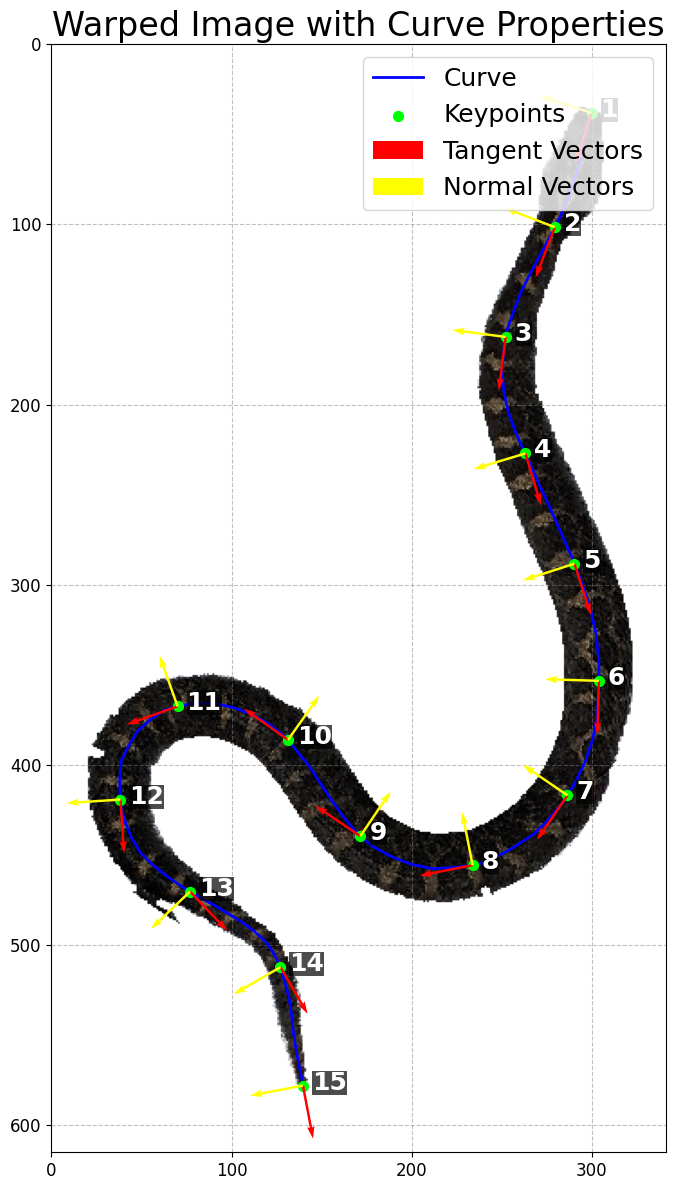

In [36]:
image_folder = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample'
output_folder = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_sample\illustrate_kgot_fill'
coco_json = r'D:\Personal_Project\snake_straightening\data\isIDD_v2\label\all_1024\all_annotations_easy_1024.json'

circulate_image_from_coco(coco_json, image_folder, output_folder, output_width=1024, output_height=1024, scale=True)